# Problem 1 - a simple distribution

We start with a worked example of a Hierarchical Bayesian Model.  We are going to make some data from a simple Gaussian distribution and add on some observational uncertainty.  We will make the data look like the luminosity (or absolute magnitude) of the red clump.

The distribution of the K-band Magnitufe of the red clump will be defined as:

$K_{\rm RC} \sim \mathcal{N}(-1.61, 0.03)$.

For now, assume we have some magic machine that measures stellar absolute magnitudes in the K band with an observational uncertainty of 0.05 magnitudes.  If we have $N$ stars which we will label with the index $i = 1,2,..., N$ then the measured magnitude will be:

$K_{i, {\rm obs}} \sim \mathcal{N}(K_{i, {\rm true}}, 0.05)$.

Let's set up this data.

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


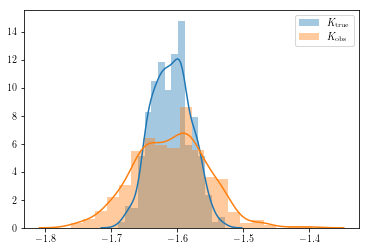

In [122]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

N = 500
RCK = -1.61
RCS = 0.03
K_true = np.random.randn(N) * RCS + RCK
sigma_K_obs = np.ones(N) * 0.05
K_obs = K_true + np.random.randn(N) * sigma_K_obs

ax = sns.distplot(K_true, label=r'$K_{\rm true}$')
ax = sns.distplot(K_obs, label=r'$K_{\rm obs}$')
ax.legend()

It is immediately obvious, that if we were to try an estimate the spread of K-band Magnitudes for the red clump from the observed data just by measuring the standard deviation we would find an overestimate.

In [123]:
print(f'Observed data: mean = {K_obs.mean():.4f}; std = {K_obs.std(ddof=1):.4f}; ' + 
      f'error on mean = {K_obs.std(ddof=1) / N**0.5:.4f}')
print(f'True data: mean = {K_true.mean():.4f}; std = {K_true.std(ddof=1):.4f};  ' +
      f'error on mean = {K_true.std(ddof=1) / N**0.5:.4f}')

Observed data: mean = -1.6096; std = 0.0554; error on mean = 0.0025
True data: mean = -1.6091; std = 0.0294;  error on mean = 0.0013


What we want is a method that takes the observed data and estimates the spread in the true data.  I guess this can be done a number of ways but here we will look at an HBM using latent variables.  This HBM method will scale very nicely with more complex problems.

Let's jump right in a build an acyclic graph to visualise our problem:

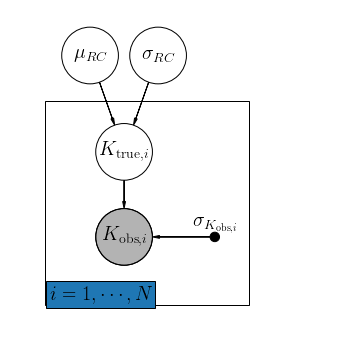

In [83]:
from matplotlib import rc
rc("font", family="serif", size=20)
rc("text", usetex=True)
import daft
pgm = daft.PGM([3,3], grid_unit=4, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("mu", r"$\mu_{RC}$", 0.7, 2.6))
pgm.add_node(daft.Node("sigma", r"$\sigma_{RC}$", 1.3, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("K_true", r"$K_{{\rm true},i}$", 1, 1.75))
# Data.
pgm.add_node(daft.Node("K_obs", r"$K_{{\rm obs},i}$", 1, 1, observed=True))
pgm.add_node(daft.Node("err", r"$\sigma_{K_{{\rm obs},i}}$", 1.8, 1.0, fixed=True, offset=[0.0,0.4]))
# Add in the edges.
pgm.add_edge("mu", "K_true")
pgm.add_edge("sigma", "K_true")
pgm.add_edge("K_true", "K_obs")
pgm.add_edge("err", "K_obs")
# And a plate.
pgm.add_plate(daft.Plate([0.3, 0.5, 1.8, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

The red clump K-band Magnitudes are assumed to follow a Gaussian distribution with mean $\mu$ and standard deviation $\sigma$ which are both unknowns.  Each star in $N$ has an index $i$.  Each star also has a true Magnitude, which is an unknown, and an observed Magnitude which is known with some uncertainty $\sigma_{K_{{\rm obs},i}}$.  We then treat $\mu$, $\sigma$, and $[K_{{\rm true}, 1}, K_{{\rm true}, 2}, ..., K_{{\rm true}, N}]$ as parameters that are to be estimated.  

We have the following constraints:

$K_{\rm true} \sim \mathcal{N}(K_{\rm obs}, \sigma_{K_{{\rm obs}}})$.

That is, the true values of the clump K-band magnitude must be consistent with the observed values and their uncertainties.

$K_{\rm true} \sim \mathcal{N}(\mu, \sigma)$.

Which is to say, that the distribution of $K_{\rm true}$ should be consistent with a normal distribution with mean $\mu$ and standard deviation $\sigma$.

We will also add the following priors that represent our exisitng knowledge of the red clump but are designed to be weakly informative:

$\mu \sim \mathcal{N}{-1.61, 0.1}$,

and 

$\sigma \sim \mathcal{N}(0, 0.4)$,

with a lower limit on sigma of $0$.

We can code this up in stan easily!

In [133]:
code = '''
data {
    int N;  // N stars
    real Kobs[N];
    real sigmaKobs[N];
}
parameters {
    real mu;
    real<lower = 0> sigma;
    real Ktrue[N];
}
model {
    Ktrue ~ normal(Kobs, sigmaKobs);
    Ktrue ~ normal(mu, sigma);
    mu ~ normal(-1.61, 0.1);
    sigma ~ normal(0, 0.4);
}

'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_efe4a9691d5925ae5d6590eb595ece72 NOW.


The stan code is written here as a string that is passed to the StanModel object.

The first section defines the data.  Both Kobs and sigmaKobs are arrays of length N with type real.

The second section defines the parameters.  Note here we have included a lower limit on sigma of zero - negative spread does not mean much here.  We have also defined an array of parameters!  Ktrue is an array of length N.  Stan understands this and treats each value in the array as a parameter (see below).

The final section defines the model.  Here we have just made the statements we defined above about what the constraints we have are.  There are two hypoer priors on mu and sigma.  And then there are the constraints on Ktrue from Kobs and the constraint on Ktrue from mu and sigma.

The code 'sm = pystan.StanModel(model_code=code)' compiles the stan model for us to call later.

We can now run the code.

In [134]:
nchains = 4
data = {'N': N,
       'Kobs': K_obs,
       'sigmaKobs': sigma_K_obs}
fit = sm.sampling(data=data, iter=2000, chains=nchains)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Running the code is simple.  We first make a choice as to how many chains we want to run t=in Stan's HMC sampler.  A default for testing is 4 chains but you might want to increase that number for important work.

We the define a dictionary called data that holds that data objects defined in the model so that these can be passed in to the sampling method.

Finally, we fit by calling sm.sampling() passing in data, running for 1000 iterations, and setting the number of chains.

You can watch the fit proceed in the terminal window.  Running on my laptop, the fit took less than 2 seconds (note the compliation takes significantly longer).

The fit object has a plot method so we can view the results.

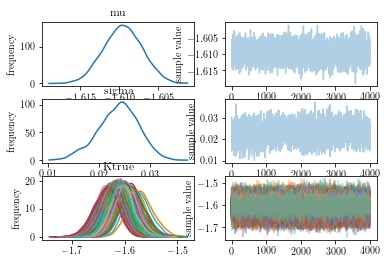

In [135]:
fit.plot()
plt.show()

We can print the fit object to see lots of useful information.  Perhaps most importantly, R_hat gives a measure of convergence.  The closer R_hat is to unity the better.  Experience suggests that all R_hat's less than 1.02 should give reasonable results.

In [136]:
print(fit)

Inference for Stan model: anon_model_efe4a9691d5925ae5d6590eb595ece72.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu          -1.61  6.2e-5 2.5e-3  -1.61  -1.61  -1.61  -1.61   -1.6   1560    1.0
sigma        0.02  4.2e-4 4.0e-3   0.02   0.02   0.02   0.03   0.03     91   1.02
Ktrue[0]    -1.62  3.6e-4   0.02  -1.67  -1.64  -1.62  -1.61  -1.58   4000    1.0
Ktrue[1]    -1.62  3.5e-4   0.02  -1.67  -1.63  -1.62  -1.61  -1.58   4000    1.0
Ktrue[2]     -1.6  3.6e-4   0.02  -1.64  -1.61   -1.6  -1.58  -1.55   4000    1.0
Ktrue[3]    -1.62  3.5e-4   0.02  -1.66  -1.63  -1.62   -1.6  -1.58   4000    1.0
Ktrue[4]     -1.6  3.5e-4   0.02  -1.64  -1.61   -1.6  -1.58  -1.55   4000    1.0
Ktrue[5]     -1.6  3.4e-4   0.02  -1.64  -1.62   -1.6  -1.59  -1.56   4000    1.0
Ktrue[6]    -1.62  3.5e-4   0.02  -1.66  -1.63  -1.62   -1.6  -1.58   400

We can also study the detail of the fit using corner.

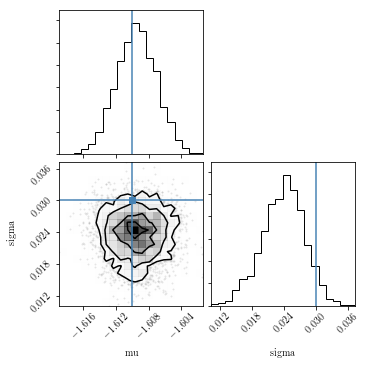

In [137]:
import corner
data = np.vstack([fit['mu'], fit['sigma']]).T
corner.corner(data, labels=['mu', 'sigma'], truths=[RCK, RCS])
plt.show()

We can see that we do a good job of recovering the real properties of the population (Ktrue).  

Here we have worked through a simple example of Hirarchical modelling in Stan.  We have treated this very simply and shown how to take a first look at the fit results of a StanModel sampling result.

In the next example, I will demonstrate another simple problem but with a sampling 'trick' that will speed up considerably lots of different applications of this simple problem.